# Building on an existing fragment

## Introduction

These functions allow you to use the RDKit module to read in a fragment. The following functions use reaction SMARTS, combined with a fragment library, to build on the existing fragments. This produces a large library of poissible modified hits. 

## Imports 

In [25]:
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import SDWriter
from rdkit.Chem.Draw import IPythonConsole
import csv
import py3Dmol

## Functions 

In [9]:
def read_in_reactions(reaction_file):
    fragment = []
    synthon1 = []
    synthon2 = []
    reaction_type = []
    rxn = []
    
    with open(reaction_file, 'rb') as csvfile:
        rownum = 0
        reader = csv.reader(csvfile)
        for row in reader:
            if rownum == 0 or rownum == 1:
                rownum += 1
            else:
                reaction_type.append(row[0])
                smarts_substructure = row[1]
                reaction_smarts = row [2]
                rxn.append(row[2])
                
                retro = reaction_smarts.split(">>")
                fragment.append(retro[0])
                synthons = retro[1].split('.')
                synthon1.append(synthons[0])
                synthon2.append(synthons[1])
                
                rownum += 1
                
    substruct_to_rxn = dict(zip(fragment, reaction_type))
    rxn_to_frag = dict(zip(reaction_type, fragment))
    rxn_to_syn1 = dict(zip(reaction_type, synthon1))
    rxn_to_syn2 = dict(zip(reaction_type, synthon2))
    rxn_to_rxnSmarts = dict(zip(reaction_type, rxn))
    
    return substruct_to_rxn, rxn_to_frag, rxn_to_syn1, rxn_to_syn2, rxn_to_rxnSmarts

In [10]:
def search_substructure_in_mols(mols, substruct_to_rxn):
    for h in xrange(len(mols)):
        m = mols[h]
        for substruct, rxn in substruct_to_rxn.iteritems():
            if m.HasSubstructMatch(Chem.MolFromSmarts(substruct)):
                print "Molecule %i: %s"%(h+1, rxn)
    return

In [11]:
def retrosynthesis(m, reaction, rxn_to_frag, rxn_to_rxnSmarts):
#     m = mols[molID]
    SmartsPatt=rxn_to_frag[reaction]
    patt = Chem.MolFromSmarts(SmartsPatt)
    rxn = AllChem.ReactionFromSmarts(rxn_to_rxnSmarts[reaction])
    
    print "*"*10, "RETROSYNTHESISNG","*"*10
    if m.HasSubstructMatch(patt):
        print "Number of reactants is: ", rxn.GetNumReactantTemplates()
        ps = rxn.RunReactants((m,))
        print "Number of products is: ",len(ps[0])
        print "SMILES for synthon 1:\t%s "%(Chem.MolToSmiles(ps[0][0]))
        print "SMILES for synthon 2:\t%s "%(Chem.MolToSmiles(ps[0][1]))
    else:
        print "No match for this reaction."
        ps = None
    print "*"*38
    return ps

In [12]:
def read_maybridge(smiles, reaction, rxn_to_syn1, rxn_to_syn2):
    hits = []
    if Chem.MolFromSmiles(smiles).HasSubstructMatch(Chem.MolFromSmarts(rxn_to_syn1[reaction])):
        search_syn = rxn_to_syn2[reaction] 
    elif Chem.MolFromSmiles(smiles).HasSubstructMatch(Chem.MolFromSmarts(rxn_to_syn2[reaction])):
        search_syn = rxn_to_syn1[reaction]
    else:
        "Error"
    search_syn_patt = Chem.MolFromSmarts(search_syn)
    maybridge = Chem.SDMolSupplier('./maybridgepoisedlibrary.sdf')
    maybridge = [x for x in maybridge if x]
    print "Finished reading in library"
    print "The length of library is: ",len(maybridge)
    print "Searching for substructure ", search_syn,"in library..."
    for i in xrange(len(maybridge)):
        if maybridge[i].HasSubstructMatch(search_syn_patt):
            hits.append(Chem.MolToSmiles(maybridge[i]))
    print "*"*38
    print "Total Maybridge reagents in library to react:\t%i\n" % len(hits),"*"*38 
    print hits
    
    if len(hits) == 0:
        print "NO HITS FOUNDS....."
        hits = None
    
    return hits

In [13]:
def forward_rxn_smarts(reaction,rxn_to_frag,rxn_to_syn1,rxn_to_syn2):
    forward = []
    forward.extend((rxn_to_syn1[reaction],".",rxn_to_syn2[reaction],">>",rxn_to_frag[reaction]))
    #    print ''.join(forward)
    return ''.join(forward)

def forward_rxn(smiles,ps,hits,reaction,rxn_to_frag,rxn_to_syn1,rxn_to_syn2):
    forward = forward_rxn_smarts(reaction,rxn_to_frag,rxn_to_syn1,rxn_to_syn2)
    print "*"*10, "FORWARD SYNTHESISING","*"*10
    print "Applying reaction:\t", forward
    
    pdts = []
    for hit in hits:
        if Chem.MolFromSmiles(smiles).HasSubstructMatch(Chem.MolFromSmarts(rxn_to_syn1[reaction])):
            r1 = Chem.MolFromSmiles(Chem.MolToSmiles(ps[0][0]))
            r2 = Chem.MolFromSmiles(hit)
        elif Chem.MolFromSmiles(smiles).HasSubstructMatch(Chem.MolFromSmarts(rxn_to_syn2[reaction])):
            r2 = Chem.MolFromSmiles(Chem.MolToSmiles(ps[0][1]))
            r1 = Chem.MolFromSmiles(hit)
        rxn = AllChem.ReactionFromSmarts(forward)
        fps = rxn.RunReactants((r1,r2))
#         print "Number of reactants is: ", rxn.GetNumReactantTemplates()
#         print "Reactant 1 is:\t", Chem.MolToSmiles(r1)
#         print "Reactant 2 is:\t", Chem.MolToSmiles(r2)
#         print "Number of products is: ", rxn.GetNumProductTemplates()
#         print "Number of entries is: ",len(fps)
#         print "SMILES for entry 1 product:\t%s "%(Chem.MolToSmiles(fps[0][0]))
        for fp in fps:
            for f in fp:
                pdts.append(f)
    print "Generated %i molecules." % len(pdts)
    print "*"*41
    return pdts

## Main: 

The RDKit module is extremely useful at handling all your moulecular needs. The block below shows how you can read in and visulise molecules in RDKit:

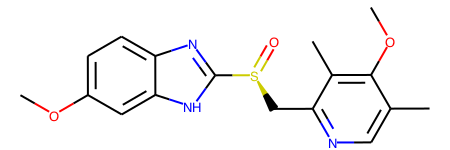

In [14]:
test_mol = Chem.MolFromSmiles('COc1ccc2c(c1)[nH]c(n2)[S@@](=O)Cc1ncc(c(c1C)OC)C')
test_mol

We can use this to input our framgent hit. You can be creative if you want, or leave the current compound in there:

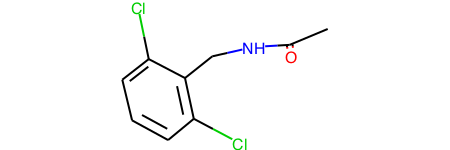

In [15]:
input_hit = Chem.MolFromMolFile("./5enc_5QD.sdf")
input_hit

You can see the hit in its protein binding site, this is a hit for a bromodomain 5ENC

In [16]:
import py3Dmol
view = py3Dmol.view(query='pdb:5enc')
view.setStyle({'cartoon':{'color':'spectrum'}})
view.setStyle({'resn':'5QD','byres':'true'},{'stick':{'colorscheme':"greenCarbon"}})
view

RDKit can also read in PDB files and AA sequences. More can be found online at:
https://github.com/rdkit/rdkit-tutorials/blob/master/notebooks/001_ReadingMolecules1.ipynb

Now that we have a target, we need to import some chemical reactions that can be used to modify the fragment

In [17]:
substruct_to_rxn, rxn_to_frag, rxn_to_syn1, rxn_to_syn2, rxn_to_rxnSmarts = read_in_reactions('reactionfile.csv')

###### Next look for possible reactions the input hit can be made from

In [18]:
search_substructure_in_mols([input_hit], substruct_to_rxn)

Molecule 1: Amides


In [19]:
reaction = "Amides"
ps = retrosynthesis(input_hit, reaction, rxn_to_frag, rxn_to_rxnSmarts)

********** RETROSYNTHESISNG **********
Number of reactants is:  1
Number of products is:  2
SMILES for synthon 1:	CC(=O)Cl 
SMILES for synthon 2:	NCc1c(Cl)cccc1Cl 
**************************************


### Choose which synthon you would like to take forward for reactions

In [20]:
hit_sm_for_rxn = "NCc1c(Cl)cccc1Cl"
reagents = read_maybridge(hit_sm_for_rxn, reaction, rxn_to_syn1, rxn_to_syn2)

Finished reading in library
The length of library is:  277
Searching for substructure  [C:1](=[O:2])-[ClD1,OD1] in library...
**************************************
Total Maybridge reagents in library to react:	59
**************************************
['O=C(O)c1ccccc1-c1cccs1', 'O=C(O)c1ccco1', 'O=C(O)C1c2ccccc2Oc2ccccc21', 'Cc1ccsc1C(=O)O', 'O=C(O)c1ccc(F)c(F)c1F', 'O=C(O)c1ccc(N2CCCCC2)cc1', 'CC1(C)Cc2cccc(C(=O)O)c2O1', 'O=C(O)c1cccc(-c2ccncc2)c1', 'O=C(O)c1csc(-c2ccc(C(F)(F)F)cc2)n1', 'O=C(O)c1ccc(-c2ccccc2)s1', 'Nc1cccc(F)c1C(=O)O', 'O=C(O)Cc1coc2ccccc12', 'O=C(O)c1ccc(OCc2ccccc2)cc1', 'Cc1c(C(=O)O)oc2ccccc12', 'Cc1nc(-c2cccc(C(=O)O)c2)cs1', 'CNc1ccc(C(=O)O)cc1', 'O=C(O)c1ccc(-c2ccncc2)cc1', 'O=C(O)c1cccc(-c2nccs2)c1', 'O=C(O)CC1CCOCC1', 'O=C(O)c1ccncc1', 'O=C(O)c1csc(-c2cccs2)n1', 'CCNc1ccc(C(=O)O)cc1', 'O=C(O)c1c[nH]cn1', 'Cl.O=C(O)CCCN1CC=C(c2ccccc2)CC1', 'O=C(O)c1csc2ccccc12', 'O=C(O)c1cc(Cl)nc(Cl)c1', 'O=C(O)c1ccc(-c2ccco2)s1', 'O=C(O)c1ccc(Cc2cccs2)cc1', 'O=C(O)c1ccsc1', 'Cc

React them all?

In [21]:
pdts = forward_rxn(hit_sm_for_rxn, ps, reagents,reaction,rxn_to_frag,rxn_to_syn1,rxn_to_syn2)

********** FORWARD SYNTHESISING **********
Applying reaction:	[C:1](=[O:2])-[ClD1,OD1].[N!H0:3]>>[C:1](=[O:2])[N:3]
Generated 59 molecules.
*****************************************


Congratulations! You made some molecules! 

/Users/joe/anaconda2/envs/fragenv/lib/python2.7/site-packages/rdkit/Chem/Draw/IPythonConsole.py:172: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn("Truncating the list of molecules to be displayed to %d. Change the maxMols value to display more."%(maxMols))


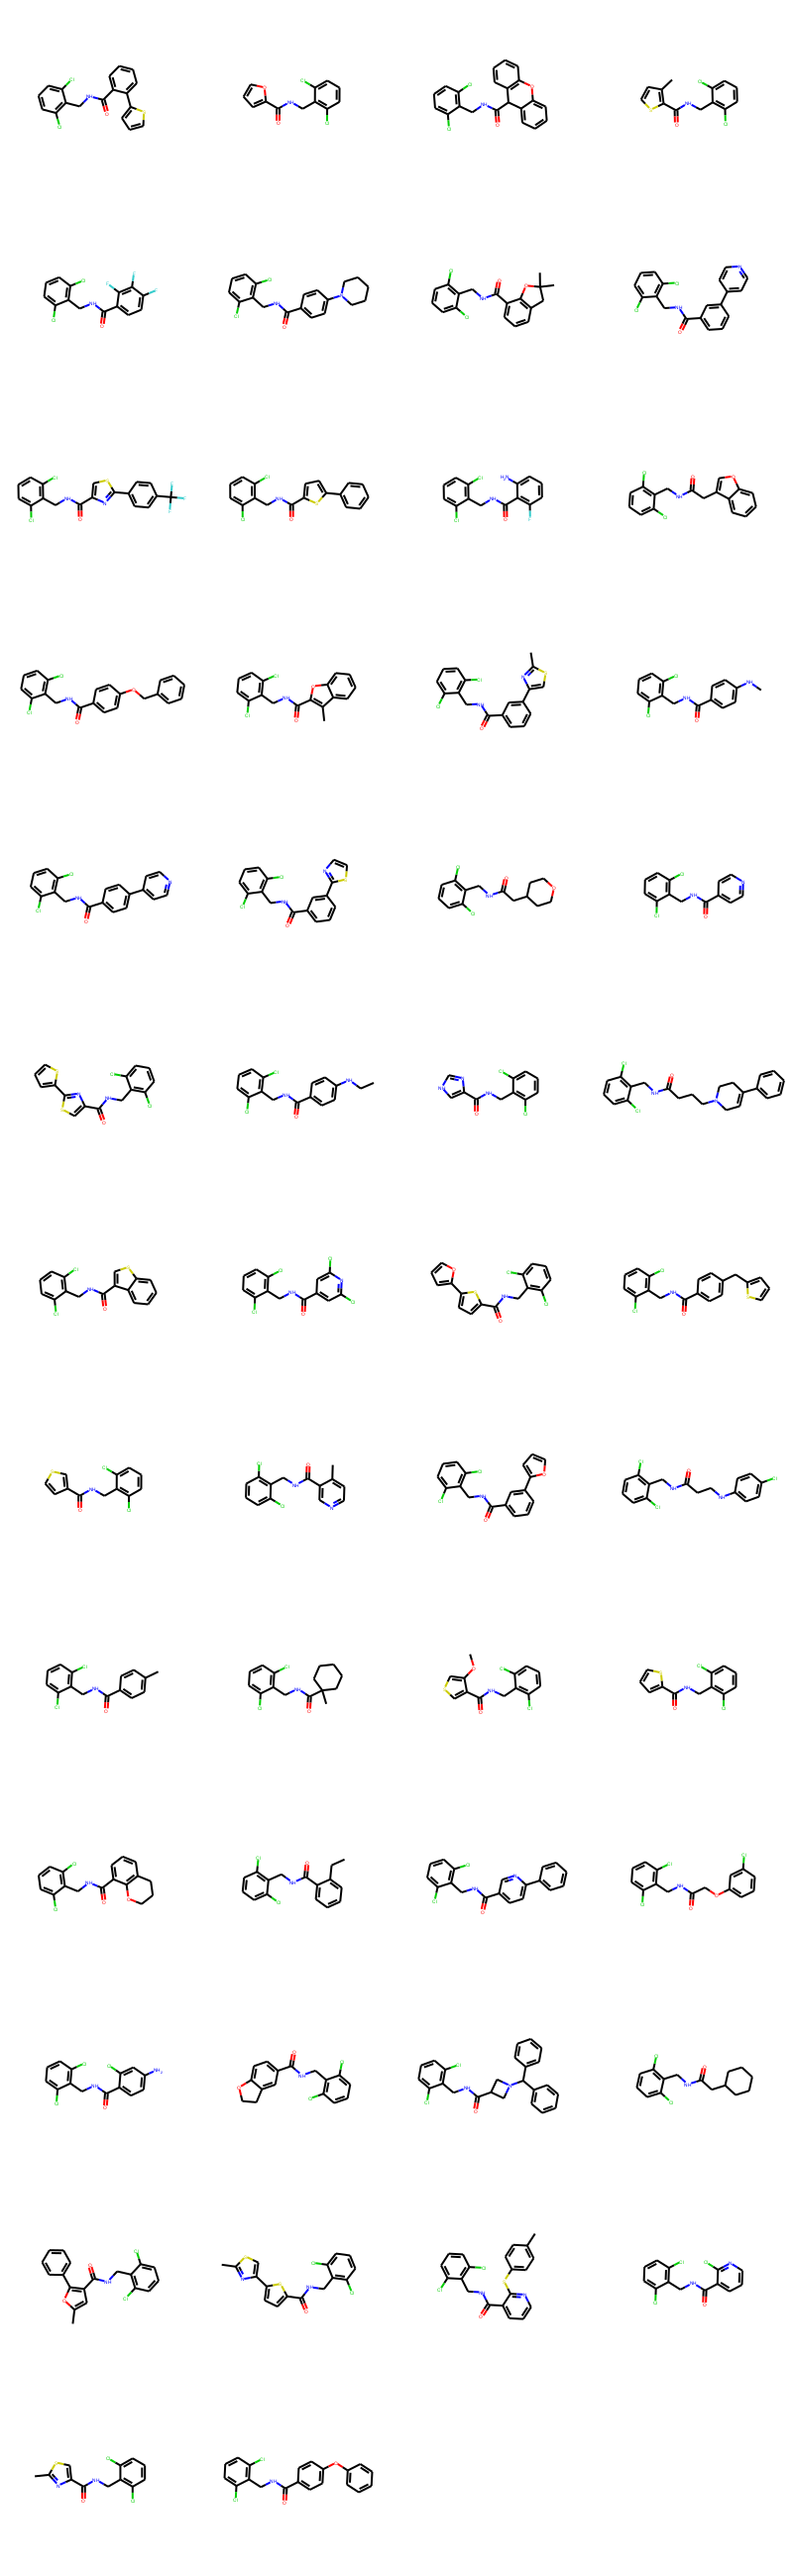

In [22]:
Draw.MolsToGridImage(pdts[:],molsPerRow=4,subImgSize=(200,200))

Now to save them for scoring:

In [27]:
writer = SDWriter('frags_output.sdf')
for mol in pdts:
    writer.write(mol)